# Unsupervised learning by competing hidden units vs backpopagation
 
 - Gloria Isotton
 - Master degree in Physics of data

In [1]:
# Importing dependencies

import torch
import torchvision
from PIL import Image
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import random
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset loading
Variable containing the dataset name `data_name`:
- `1` : MNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?ref=hackernoon.com#torchvision.datasets.MNIST <br>
- `2` : CIFAR10 https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html?ref=hackernoon.com#torchvision.datasets.CIFAR10<br>
- `3` : FashionMNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html?ref=hackernoon.com#torchvision.datasets.FashionMNIST<br>

In [32]:
data_name=3
dataset_name = 'fashion_mnist' 

####### MNIST dataset ########
if data_name == 1:
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)

    train_size = 50000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=28, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")


####### CIFAR10 dataset ########
if data_name == 2:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.Lambda(lambda x: x.view(-1))])
    full_train_dataset = datasets.CIFAR10(root="data", download=True, train=True, transform=transform)

    train_size = 40000
    val_size = 10000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



####### FASHION MNIST dataset ########
if data_name == 3:
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),
                                   transforms.Lambda(lambda x: x.view(-1))])

    full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
    train_size = 10000
    val_size = 50000
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=28,shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=28,shuffle=False)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")



Training set size: 10000
Test set size: 50000


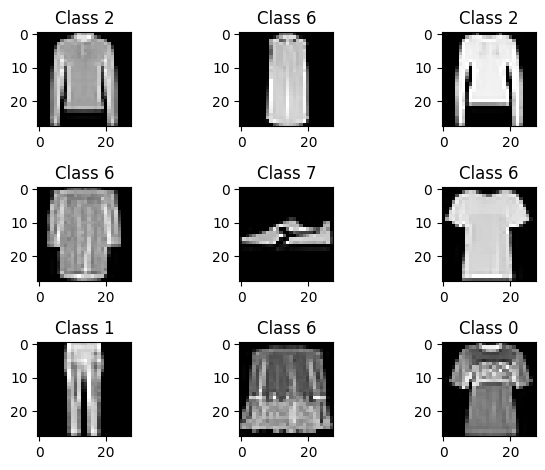

In [33]:
# extract images and labels from training dataset for plotting
X_train = train_dataset.dataset.data
y_train = train_dataset.dataset.targets

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()



# Simple backpropagation model
The structure of the network is: N_input -> N_hidden -> 10, with N_input varying from the dataset and n_hidden being the number of neurons in the single hidden layer that yelds to best performances in the biological network. 

In [34]:
# Define the model class
class BPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.fc2(x)
        #x = self.softmax(x)
        return x

In [35]:
### Parameters
num_epochs = 80
n_input =  784 #3072 
n_hidden = 1000
batch_size = 100
learning_rate = 0.02
Kx = 10
Ky = 10
out_features = 10

# Create an instance of the image classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = BPModel(n_input, n_hidden, out_features).to(device)

# Define the optimizer and loss function
optimizer = Adam(classifier.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [36]:
classifier

BPModel(
  (fc1): Linear(in_features=784, out_features=1000, bias=True)
  (relu): ReLU()
  (batch_norm): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Training

In [37]:
### Training and Logging
train_loss_log = []
test_loss_log = []
test_accuracy_log = []  # To store test accuracy
train_accuracy_log =[]

### Training with Adam
for num_ep in range(num_epochs):

    # Training Loop (mini-batch training)
    classifier.train()  # Set model to training mode
    train_loss_vec = []  # Initialize list for training losses
    correct = 0
    total = 0

    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device) # when using cuda
        optimizer.zero_grad()  # Zero the parameter gradients
        output = classifier(images)  # Forward pass
        loss = loss_fn(output, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        train_loss_vec.append(loss.item())  # Store loss for each mini-batch
        pred_label = output.argmax(dim=1)  
        correct += pred_label.eq(labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Total samples
    
    train_loss_log.append(np.mean(train_loss_vec))  # Store average loss for this epoch
    train_accuracy_log.append(100. * correct / total) 

    # Testing Loop (test set evaluation)
    classifier.eval()  # Set model to evaluation mode
    test_loss_vec = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            
            images, labels = images.to(device), labels.to(device) # when using cuda
            output = classifier(images)  # Forward pass
            loss = loss_fn(output, labels)  # Compute test loss
            test_loss_vec.append(loss.item())  # Store loss for each batch
            
            pred_label = output.argmax(dim=1)  # Get predicted labels
            correct += pred_label.eq(labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Total samples
    
    test_loss_log.append(np.mean(test_loss_vec))  # Store average test loss
    test_accuracy_log.append(100. * correct / total)  # Store test accuracy

    # Print epoch details
    print(f'Epoch {num_ep + 1}/{num_epochs} - Train loss: {np.mean(train_loss_log):.5f} -Train acc: {np.mean(train_accuracy_log):.5f} - Test loss: {np.mean(test_loss_log):.5f} - Accuracy: {test_accuracy_log[-1]:.2f}%')
 

### Save the weights and the loss history

torch.save(classifier.state_dict(), f'./output_ffnn/{dataset_name}_bkpg_linear.pt')


with open(f"./output_ffnn/{dataset_name}_bkpg_linear_hidden{n_hidden}.txt", "w") as f:
    f.write("N_hidden\tVal_Acc\tTrain_Acc\tVal_loss\tTrain_loss\n")
    f.write(f"{n_hidden}\t{np.mean(test_accuracy_log[-10:]):.4f}\t{np.mean(train_accuracy_log[-10:]):.4f}\t{np.mean(test_loss_log[-10:]):.4f}\t{np.mean(train_loss_log[-10:]):.4f}\n")


Epoch 1/80 - Train loss: 1.00444 -Train acc: 72.87000 - Test loss: 2.35213 - Accuracy: 75.57%
Epoch 2/80 - Train loss: 0.80856 -Train acc: 76.00500 - Test loss: 3.16851 - Accuracy: 79.27%
Epoch 3/80 - Train loss: 0.71952 -Train acc: 77.63667 - Test loss: 3.17150 - Accuracy: 80.92%
Epoch 4/80 - Train loss: 0.67131 -Train acc: 78.63500 - Test loss: 2.69501 - Accuracy: 81.24%
Epoch 5/80 - Train loss: 0.64458 -Train acc: 79.18400 - Test loss: 2.54575 - Accuracy: 81.91%
Epoch 6/80 - Train loss: 0.61703 -Train acc: 79.88333 - Test loss: 2.63143 - Accuracy: 81.77%
Epoch 7/80 - Train loss: 0.59592 -Train acc: 80.43571 - Test loss: 3.44558 - Accuracy: 80.74%
Epoch 8/80 - Train loss: 0.58057 -Train acc: 80.83250 - Test loss: 3.33275 - Accuracy: 79.77%
Epoch 9/80 - Train loss: 0.56407 -Train acc: 81.25000 - Test loss: 3.24765 - Accuracy: 80.85%
Epoch 10/80 - Train loss: 0.54960 -Train acc: 81.62400 - Test loss: 3.36586 - Accuracy: 81.93%
Epoch 11/80 - Train loss: 0.53921 -Train acc: 81.91455 - Te

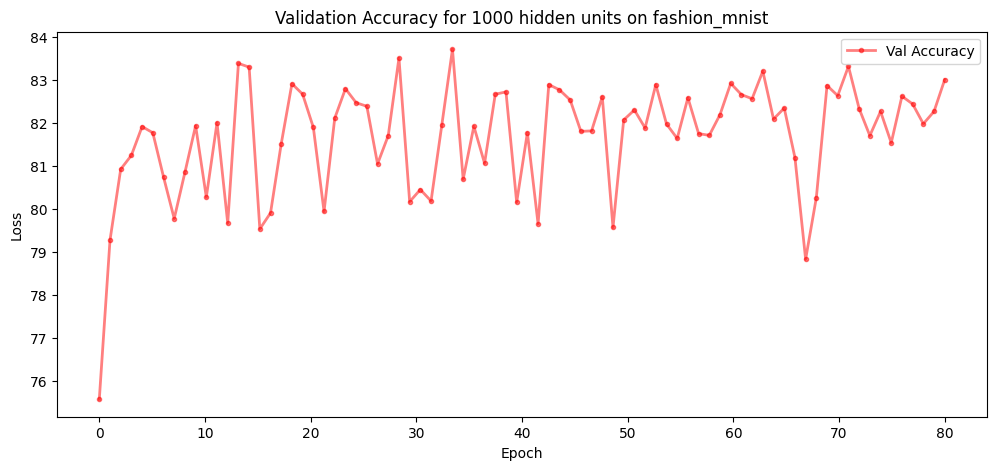

In [38]:
# Plotting
# Dizionario dei nomi dei dataset
data_name_dict = {1: "MNIST", 2: "CIFAR10", 3: "FashionMNIST"}
dataset_name = data_name_dict.get(data_name, "UnknownDataset")
dataset_name = 'fashion_mnist'
# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(np.linspace(0, len(test_accuracy_log), len(test_accuracy_log)), test_accuracy_log, '.-', label='Val Accuracy', color='red', lw=2, alpha=0.5)
#plt.plot(np.linspace(0, len(test_accuracy_log), len(test_accuracy_log)), test_loss_log, '.-', label='Val Loss', color='blue', lw=2, alpha=0.5)
plt.title(f'Validation Accuracy for {n_hidden} hidden units on {dataset_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'./output_ffnn/{dataset_name}_bkpg_{n_hidden}hu_{out_features}out_{num_epochs}ep_acc.png')
plt.show()



### Draw the weights of first layer

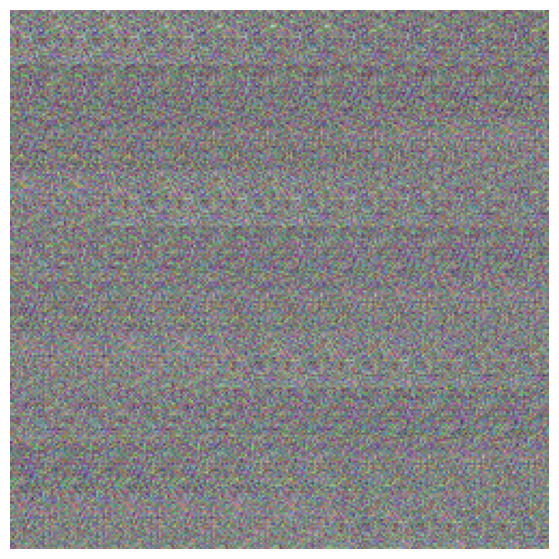

In [67]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    fig=plt.figure(figsize=(10, 7))

    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1

    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max()
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw()
    
bp_weights = classifier.fc1.weight.data.T
bp_weights.shape
draw_weights(bp_weights.cpu(), Kx=10, Ky=10)
plt.savefig(f'./output_ffnn/{dataset_name}_bkpg_fc1.png')

### Backpropagation accuracy vs hidden units

In [16]:
def backpropagation(num_epochs, classifier,train_loader, test_loader, device,optimizer):

    train_loss_log = []
    train_acc_log = []
    test_loss_log = []
    test_accuracy_log = []  # To store test accuracy

    ### Training with Adam
    for num_ep in range(num_epochs):

        # Training Loop (mini-batch training)
        classifier.train()  # Set model to training mode
        total_loss, correct, total = 0, 0, 0 # Initialize list for training losses
        
        for images, labels in train_loader:
            
            images, labels = images.to(device), labels.to(device) # when using cuda
            optimizer.zero_grad()  # Zero the parameter gradients
            output = classifier(images)  # Forward pass
            loss = loss_fn(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            total_loss += loss.item()* images.size(0)  # Store loss for each mini-batch
            correct += (output.argmax(1) == labels).sum().item()
            total += labels.size(0) 
        
        # Calculate average loss and accuracy for the epoch
        train_loss = total_loss / len(train_loader.dataset)
        train_accuracy = 100.*correct / total

        # Store training logs
        train_loss_log.append(train_loss)
        train_acc_log.append(train_accuracy)

        
        # Testing Loop (test set evaluation)
        classifier.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                
                images, labels = images.to(device), labels.to(device) # when using cuda
                output = classifier(images)  # Forward pass
                loss = loss_fn(output, labels)  # Compute test loss
                
                pred_label = output.argmax(dim=1)  # Get predicted labels
                total_loss += loss.item()* images.size(0)
                correct += (output.argmax(1) == labels).sum().item() # pred_label.eq(labels).sum().item()  # Count correct predictions
                total += labels.size(0)  # Total samples
        
        test_loss_log.append(total_loss/len(test_loader.dataset))  # Store average test loss
        test_accuracy_log.append(100. * correct / total)  # Store test accuracy
        
        print(f'Epoch {num_ep + 1}/{num_epochs} - Train loss: {np.mean(train_loss_log):.5f} - Test loss: {np.mean(test_loss_log):.5f} - Accuracy: {test_accuracy_log[-1]:.2f}%')

    return train_loss_log, test_loss_log, train_acc_log, test_accuracy_log

In [17]:
N_hid_list = list(np.arange(2,20,3)) + list(np.arange(20,500,20))+ list(np.arange(500,1500,100))
val_acc_avg = []
train_acc_avg = []

### Parameters
num_epochs = 80
n_input = 784 
batch_size = 100
learning_rate = 0.02
Kx = 10
Ky = 10
out_features = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_acc_avg = []
train_acc_avg = []
for i,n_hidden in enumerate(N_hid_list):
    print(f'training with {n_hidden} units:')

    # Create an instance of the image classifier model
    classifier = BPModel(n_input, n_hidden, out_features).to(device)

    # Define the optimizer and loss function
    optimizer = Adam(classifier.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_log, test_loss_log, train_acc_log, test_accuracy_log = backpropagation(num_epochs, classifier,train_loader, test_loader, device,optimizer)

    val_acc_avg.append(np.mean(test_accuracy_log[-10:]))
    train_acc_avg.append(np.mean(train_acc_log[-10:]))
    print(f'results: val_acc_avg = {val_acc_avg[i]}   train_acc_avg = {train_acc_avg[i]}')



training with 2 units:
Epoch 1/80 - Train loss: 1.27652 - Test loss: 7.46758 - Accuracy: 62.64%
Epoch 2/80 - Train loss: 1.20590 - Test loss: 7.11145 - Accuracy: 62.88%
Epoch 3/80 - Train loss: 1.17659 - Test loss: 6.95525 - Accuracy: 63.36%
Epoch 4/80 - Train loss: 1.15964 - Test loss: 6.86344 - Accuracy: 63.14%
Epoch 5/80 - Train loss: 1.14903 - Test loss: 6.80817 - Accuracy: 64.26%
Epoch 6/80 - Train loss: 1.14078 - Test loss: 6.76374 - Accuracy: 65.58%
Epoch 7/80 - Train loss: 1.13553 - Test loss: 6.73343 - Accuracy: 65.03%
Epoch 8/80 - Train loss: 1.13110 - Test loss: 6.70710 - Accuracy: 65.11%
Epoch 9/80 - Train loss: 1.12734 - Test loss: 6.68545 - Accuracy: 65.34%
Epoch 10/80 - Train loss: 1.12435 - Test loss: 6.66819 - Accuracy: 65.16%
Epoch 11/80 - Train loss: 1.12173 - Test loss: 6.65333 - Accuracy: 65.53%
Epoch 12/80 - Train loss: 1.11929 - Test loss: 6.64011 - Accuracy: 65.24%
Epoch 13/80 - Train loss: 1.11707 - Test loss: 6.62829 - Accuracy: 65.12%
Epoch 14/80 - Train loss

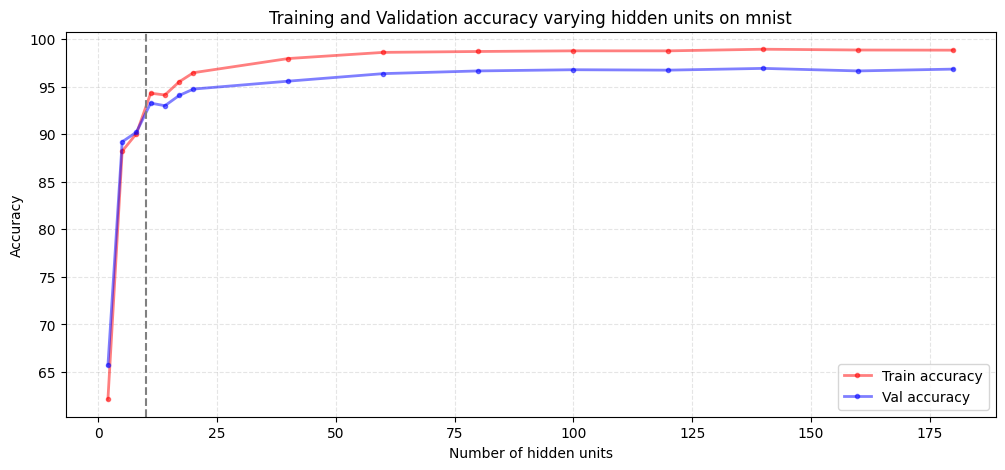

In [20]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(N_hid_list[:15], train_acc_avg[:15], '.-', label='Train accuracy', color='red', lw=2, alpha=0.5)
plt.plot(N_hid_list[:15], val_acc_avg[:15], '.-', label='Val accuracy', color='blue', lw=2, alpha=0.5)
plt.title(f'Training and Validation accuracy varying hidden units on mnist')
plt.xlabel('Number of hidden units')
plt.ylabel('Accuracy')
plt.axvline(x=10, color='grey', linestyle='--')
plt.legend()
plt.savefig(f'mnist_BACKPROP_hu_vs_acc.png')
plt.grid(color='grey', linestyle='--', alpha=0.2)
plt.show()

In [21]:
with open("mnist_BACKPROP_hu_vs_acc_data.txt", "w") as f:
    f.write("N_hidden\tVal_Acc\tTrain_Acc\n")
    for nh, va, ta in zip(N_hid_list, val_acc_avg, train_acc_avg):
        f.write(f"{nh}\t{va:.4f}\t{ta:.4f}\n")

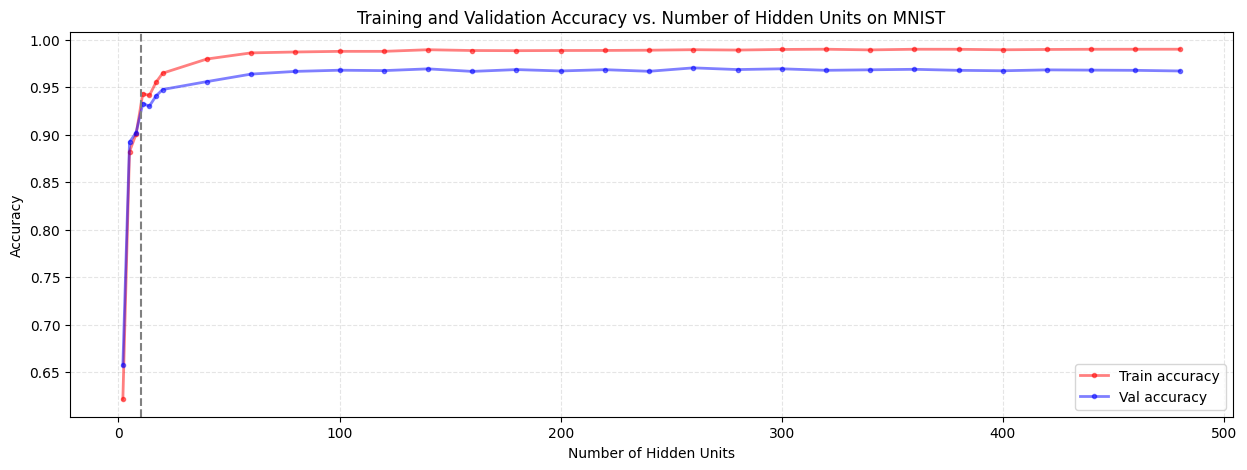

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Read the file
N_hid_list = []
val_acc_avg = []
train_acc_avg = []

with open("mnist_BACKPROP_hu_vs_acc_data.txt", "r") as f:
    next(f)  # Skip header
    for line in f:
        nh, val_acc, train_acc = line.strip().split("\t")
        N_hid_list.append(int(nh))
        val_acc_avg.append(float(val_acc))
        train_acc_avg.append(float(train_acc))

# Step 2: Plot the data
plt.figure(figsize=(15, 5))
plt.plot(N_hid_list[:30], np.array(train_acc_avg[:30])/100, '.-', label='Train accuracy', color='red', lw=2, alpha=0.5)
plt.plot(N_hid_list[:30], np.array(val_acc_avg[:30])/100, '.-', label='Val accuracy', color='blue', lw=2, alpha=0.5)

plt.title('Training and Validation Accuracy vs. Number of Hidden Units on MNIST')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Accuracy')
plt.axvline(x=10, color='grey', linestyle='--')
plt.legend()
plt.grid(color='grey', linestyle='--', alpha=0.2)
plt.savefig('mnist_hu_vs_acc.png')
plt.show()